In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

class OutlierCapper(BaseEstimator, TransformerMixin):
    def __init__(self, lower_quantile=0.01, upper_quantile=0.99):
        self.lower_quantile = lower_quantile
        self.upper_quantile = upper_quantile
        self.lower_bounds = None
        self.upper_bounds = None

    def fit(self, X, y=None):
        self.lower_bounds = np.quantile(X, self.lower_quantile, axis=0)
        self.upper_bounds = np.quantile(X, self.upper_quantile, axis=0)
        return self

    def transform(self, X):
        return np.clip(X, self.lower_bounds, self.upper_bounds)

class YearConverter(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.min_year = None
        self.max_year = None

    def fit(self, X, y=None):
        X_flat = X.ravel() if X.ndim > 1 else X
        self.min_year = np.min(X_flat)
        self.max_year = min(np.max(X_flat), pd.Timestamp.now().year)
        return self

    def transform(self, X):
        X_numeric = pd.to_numeric(X.ravel() if X.ndim > 1 else X, errors='coerce')
        X_clipped = np.clip(X_numeric, self.min_year, self.max_year)
        return X_clipped.reshape(X.shape)

class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        # Create new features
        X['TotalSF'] = X['TotalBsmtSF'] + X['1stFlrSF'] + X['2ndFlrSF']
        
        current_year = pd.Timestamp.now().year
        X['HouseAge'] = current_year - X['YearBuilt']
        X['TimeSinceRemodel'] = current_year - X['YearRemodAdd']
        
        X['TotalBathrooms'] = X['FullBath'] + (0.5 * X['HalfBath']) + X['BsmtFullBath'] + (0.5 * X['BsmtHalfBath'])
        X['IsNewHouse'] = (X['YearBuilt'] == X['YrSold']).astype(int)
        X['HasPool'] = (X['PoolArea'] > 0).astype(int)
        X['TotalPorchSF'] = X['OpenPorchSF'] + X['EnclosedPorch'] + X['3SsnPorch'] + X['ScreenPorch']
        X['OverallHouseCondition'] = X['OverallQual'] * X['OverallCond']
        
        # Create interaction features
        X['TotalSF_OverallQual'] = X['TotalSF'] * X['OverallQual']
        X['GrLivArea_TotRmsAbvGrd'] = X['GrLivArea'] * X['TotRmsAbvGrd']
        X['HouseAge_OverallQual'] = X['HouseAge'] * X['OverallQual']
        X['GarageArea_GarageCars'] = X['GarageArea'] * X['GarageCars']
        X['YearBuilt_YearRemodAdd'] = X['YearBuilt'] * X['YearRemodAdd']
        X['TotalSF_HouseAge'] = X['TotalSF'] * X['HouseAge']
        X['1stFlrSF_2ndFlrSF'] = X['1stFlrSF'] * X['2ndFlrSF']
        X['TotalSF_OverallCond'] = X['TotalSF'] * X['OverallCond']
        
        # Interaction with categorical variable (requires encoding)
        X['GrLivArea_Neighborhood'] = X['GrLivArea'] * pd.factorize(X['Neighborhood'])[0]
        
        return X

def pandas_to_numpy(X):
    return X.to_numpy() if isinstance(X, pd.DataFrame) else X

def preprocess_and_engineer(X):
    # Apply FeatureEngineer first
    feature_engineer = FeatureEngineer()
    X_engineered = feature_engineer.fit_transform(X.copy())
    
    # Identify numeric, categorical, and year columns
    numeric_features = X_engineered.select_dtypes(include=['int64', 'float64']).columns.drop(['YearBuilt', 'YearRemodAdd', 'YrSold'])
    categorical_features = X_engineered.select_dtypes(include=['object']).columns
    year_features = ['YearBuilt', 'YearRemodAdd', 'YrSold']
    
    print("Number of features before preprocessing:")
    print(f"Numeric: {len(numeric_features)}")
    print(f"Categorical: {len(categorical_features)}")
    print(f"Year: {len(year_features)}")
    
    # Create preprocessing steps
    numeric_transformer = Pipeline(steps=[
        ('imputer', KNNImputer(n_neighbors=5)),
        ('outlier_capper', OutlierCapper()),
        ('scaler', StandardScaler()),
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore', max_categories=10)),
    ])

    year_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('converter', YearConverter()),
    ])

    # Create and fit the preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features),
            ('year', year_transformer, year_features)
        ])
    
    X_preprocessed = preprocessor.fit_transform(X_engineered)
    
    # Generate feature names
    numeric_feature_names = list(numeric_features)
    categorical_feature_names = []
    onehot_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
    
    print("\nCategorical feature encoding details:")
    for i, feature in enumerate(categorical_features):
        categories = onehot_encoder.categories_[i]
        n_categories = min(len(categories), 10)  # Account for max_categories=10
        n_encoded = n_categories - 1  # Subtract 1 due to drop='first'
        print(f"{feature}: {n_categories} categories, {n_encoded} encoded features")
        categorical_feature_names.extend([f"{feature}_{cat}" for cat in categories[1:n_categories]])
    
    year_feature_names = list(year_features)
    
    feature_names = (numeric_feature_names + 
                     categorical_feature_names + 
                     year_feature_names)
    
    print("\nNumber of features after preprocessing:")
    print(f"Numeric: {len(numeric_feature_names)}")
    print(f"Categorical (one-hot encoded): {len(categorical_feature_names)}")
    print(f"Year: {len(year_feature_names)}")
    
    print(f"\nTotal number of features: {len(feature_names)}")
    print(f"Number of columns in preprocessed data: {X_preprocessed.shape[1]}")
    
    # Ensure the number of feature names matches the number of columns in X_preprocessed
    if len(feature_names) != X_preprocessed.shape[1]:
        print(f"\nWarning: Number of feature names ({len(feature_names)}) "
              f"does not match number of columns in preprocessed data ({X_preprocessed.shape[1]})")
        print("Adjusting feature names...")
        if len(feature_names) > X_preprocessed.shape[1]:
            feature_names = feature_names[:X_preprocessed.shape[1]]
        else:
            feature_names += [f'Unknown_{i}' for i in range(X_preprocessed.shape[1] - len(feature_names))]
    
    # Store feature names as an attribute of the DataFrame
    df = pd.DataFrame(X_preprocessed, columns=feature_names, index=X.index)
    df.attrs['feature_names'] = feature_names
    
    return df

# Load the data
df = pd.read_csv('/Users/ttanaka/Desktop/Website/house-prices-advanced-regression-techniques/train.csv')

# Separate features and target
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

# Full pipeline
full_pipeline = Pipeline([
    ('preprocess_and_engineer', FunctionTransformer(preprocess_and_engineer, validate=False)),
    ('to_numpy', FunctionTransformer(pandas_to_numpy))
])

# Apply the pipeline
X_processed = full_pipeline.fit_transform(X)

# Validation
print("\nFinal validation:")
print("Shape after preprocessing:", X_processed.shape)
print("Missing values after preprocessing:", np.isnan(X_processed).sum())

# Access feature names from the intermediate DataFrame
intermediate_df = full_pipeline.named_steps['preprocess_and_engineer'].transform(X)
feature_names = intermediate_df.attrs.get('feature_names', [])
print("Number of features:", len(feature_names))
print("First 10 feature names:", feature_names[:10])
print("Last 10 feature names:", feature_names[-10:])

Number of features before preprocessing:
Numeric: 51
Categorical: 43
Year: 3

Categorical feature encoding details:
MSZoning: 5 categories, 4 encoded features
Street: 2 categories, 1 encoded features
Alley: 3 categories, 2 encoded features
LotShape: 4 categories, 3 encoded features
LandContour: 4 categories, 3 encoded features
Utilities: 2 categories, 1 encoded features
LotConfig: 5 categories, 4 encoded features
LandSlope: 3 categories, 2 encoded features
Neighborhood: 10 categories, 9 encoded features
Condition1: 9 categories, 8 encoded features
Condition2: 8 categories, 7 encoded features
BldgType: 5 categories, 4 encoded features
HouseStyle: 8 categories, 7 encoded features
RoofStyle: 6 categories, 5 encoded features
RoofMatl: 8 categories, 7 encoded features
Exterior1st: 10 categories, 9 encoded features
Exterior2nd: 10 categories, 9 encoded features
MasVnrType: 5 categories, 4 encoded features
ExterQual: 4 categories, 3 encoded features
ExterCond: 5 categories, 4 encoded features

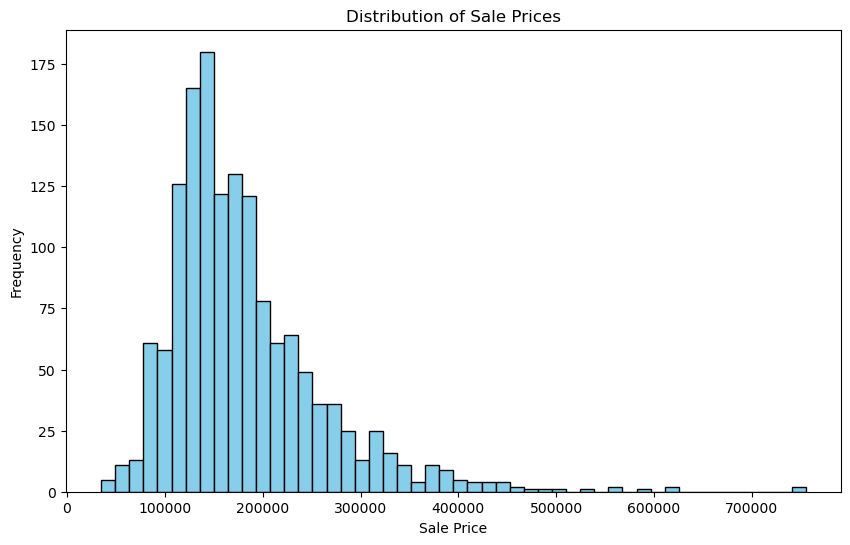

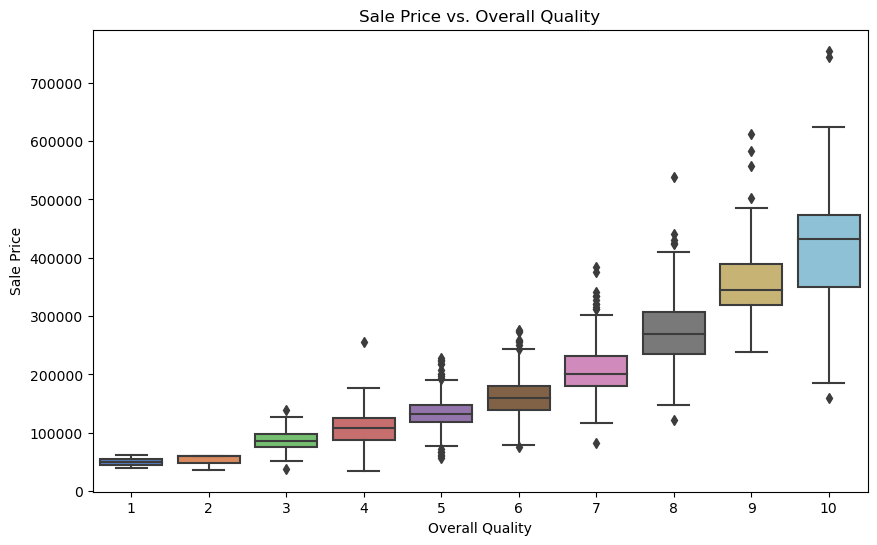

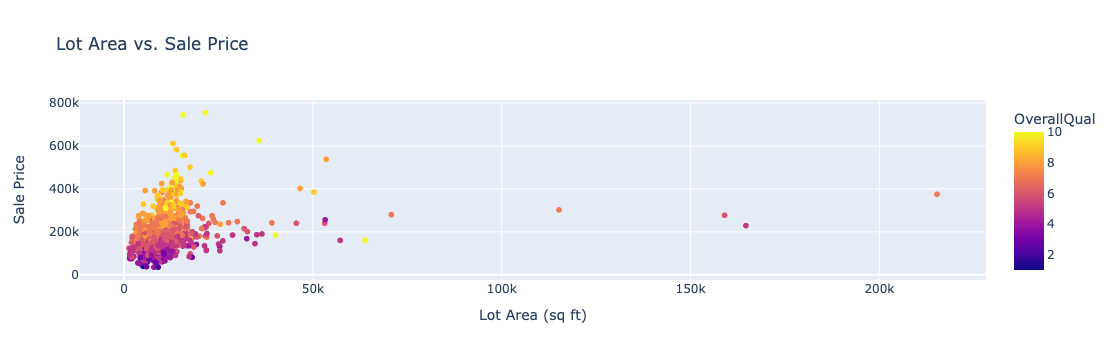

Top correlated features with SalePrice:
 Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt',
       'YearRemodAdd'],
      dtype='object')


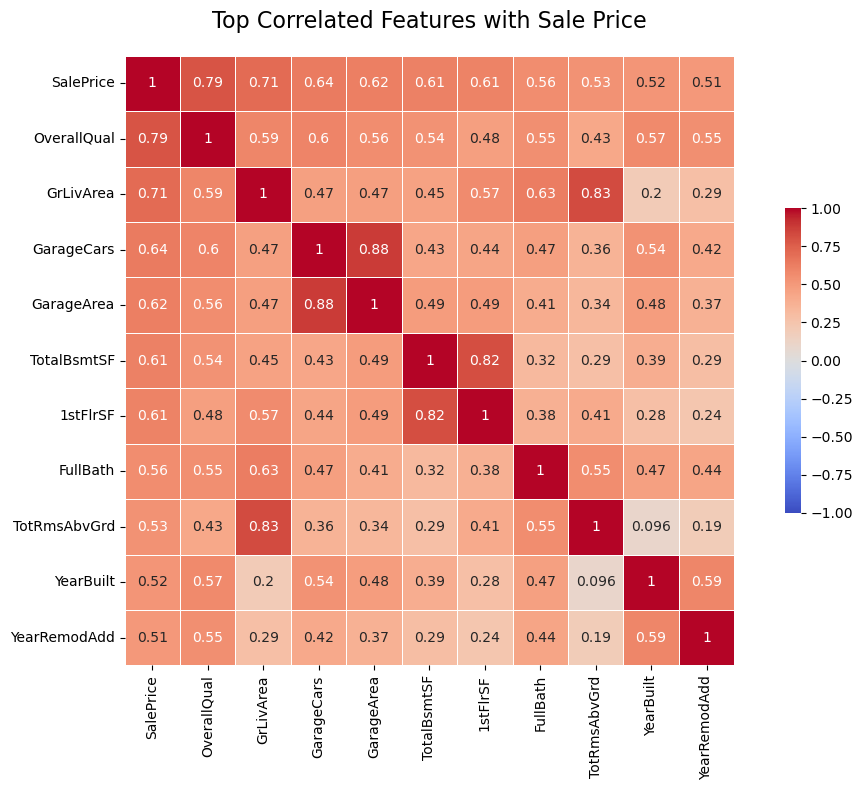

In [98]:
# Visualizations

# Sale Price Distribution
plt.figure(figsize=(10, 6))
plt.hist(df['SalePrice'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Sale Prices')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.savefig('matplotlib_sale_price_distribution.png')
plt.show()

# Sale Price vs. Overall Quality
plt.figure(figsize=(10, 6))
sns.boxplot(x='OverallQual', y='SalePrice', data=df, palette='muted')
plt.title('Sale Price vs. Overall Quality')
plt.xlabel('Overall Quality')
plt.ylabel('Sale Price')
plt.savefig('seaborn_sale_price_vs_quality.png')
plt.show()

# Create a scatter plot using Plotly
fig = px.scatter(df, x='LotArea', y='SalePrice', color='OverallQual',
                 title='Lot Area vs. Sale Price',
                 labels={'LotArea': 'Lot Area (sq ft)', 'SalePrice': 'Sale Price'},
                 hover_data=['YearBuilt'])
# Display the plot
fig.show()
# Save the plot as a PNG image
fig.write_image('plotly_lot_area_vs_sale_price.png')

# Compute the correlation matrix
corr_matrix = df.corr()
# Select the top features that correlate with 'SalePrice'
top_corr_features = corr_matrix['SalePrice'].abs().sort_values(ascending=False).head(11).index
print("Top correlated features with SalePrice:\n", top_corr_features)
# Create a new correlation matrix with the top features
top_corr_matrix = df[top_corr_features].corr()
# Create the heatmap
plt.figure(figsize=(11, 8))
sns.heatmap(top_corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar=True, square=True, 
            linewidths=0.5, cbar_kws={"shrink": .5})
plt.title('Top Correlated Features with Sale Price', fontsize=16, pad=20)
plt.tight_layout()
# Save the plot
plt.savefig('seaborn_top_corr_heatmap.png')
# Display the plot
plt.show()

In [100]:
from sklearn.feature_selection import SelectKBest, f_regression

# This uses f_regression, which is appropriate for regression problems
selector = SelectKBest(score_func=f_regression, k=10)
X_selected = selector.fit_transform(X_processed, y)

selected_feature_indices = selector.get_support(indices=True)
selected_features = [feature_names[i] for i in selected_feature_indices]

print("\nTop 10 features selected by univariate feature selection (using f_regression):")
print(selected_features)


Top 10 features selected by univariate feature selection (using f_regression):
['OverallQual', 'TotalBsmtSF', 'GrLivArea', 'GarageCars', 'TotalSF', 'TotalBathrooms', 'TotalSF_OverallQual', 'GrLivArea_TotRmsAbvGrd', 'GarageArea_GarageCars', 'TotalSF_OverallCond']


In [102]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Use X_processed instead of X
estimator = LinearRegression()
selector = RFE(estimator, n_features_to_select=10, step=1)
selector = selector.fit(X_processed, y)

# Get the mask of selected features
feature_mask = selector.support_

# Get the names of the selected features
selected_features = [feature_names[i] for i in range(len(feature_mask)) if feature_mask[i]]

print("Top 10 features selected by RFE:")
print(selected_features)

Top 10 features selected by RFE:
['Condition2_PosN', 'RoofMatl_CompShg', 'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll', 'RoofMatl_Tar&Grv', 'RoofMatl_WdShake', 'RoofMatl_WdShngl', 'PoolQC_Fa', 'PoolQC_missing']


In [91]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

# Use X_processed instead of X
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_processed, y)

# Get feature importances
importances = rf_model.feature_importances_

# Sort features by importance
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False).reset_index(drop=True)

print("Top 10 features by Random Forest importance:")
print(feature_importance_df.head(10))

Top 10 features by Random Forest importance:
                  feature  importance
0     TotalSF_OverallQual    0.807735
1     TotalSF_OverallCond    0.016542
2  YearBuilt_YearRemodAdd    0.010114
3                 LotArea    0.008518
4              BsmtFinSF1    0.008383
5               BsmtUnfSF    0.007986
6             OpenPorchSF    0.007166
7   GarageArea_GarageCars    0.006161
8    HouseAge_OverallQual    0.005684
9          TotalBathrooms    0.005231


In [105]:
import xgboost as xgb
import pandas as pd
import numpy as np

# Convert X_processed to a DataFrame if it's not already
X_processed_df = pd.DataFrame(X_processed, columns=feature_names)

# Ensure all data is numeric
for col in X_processed_df.columns:
    if X_processed_df[col].dtype == 'object':
        X_processed_df[col] = pd.factorize(X_processed_df[col])[0]

# Now fit the XGBoost model
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_processed_df, y)

# Get feature importances
importances = xgb_model.feature_importances_

# Sort features by importance
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False).reset_index(drop=True)

print("Top 10 features by XGBoost importance:")
print(feature_importance_df.head(10))

Top 10 features by XGBoost importance:
                feature  importance
0   TotalSF_OverallQual    0.432219
1        KitchenQual_TA    0.071039
2         Alley_missing    0.054369
3  Neighborhood_Blueste    0.029859
4         GarageQual_TA    0.028146
5         LandSlope_Mod    0.027403
6           MSZoning_RM    0.018765
7            GarageCars    0.018041
8          KitchenAbvGr    0.015699
9          SaleType_New    0.014757


In [107]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# Fit OLS model
ols = LinearRegression()
ols.fit(X_processed, y)

# Perform cross-validation
ols_scores = cross_val_score(ols, X_processed, y, cv=5, scoring='neg_mean_squared_error')
print(f"OLS Cross-Validation MSE: {-ols_scores.mean():.4f} (+/- {ols_scores.std() * 2:.4f})")

# Get coefficients
ols_coef = pd.DataFrame({'feature': feature_names, 'coefficient': ols.coef_})
print("\nTop 5 positive and negative OLS coefficients:")
print(ols_coef.sort_values('coefficient', ascending=False).head())
print(ols_coef.sort_values('coefficient', ascending=True).head())

OLS Cross-Validation MSE: 1377330606.2392 (+/- 982155553.6464)

Top 5 positive and negative OLS coefficients:
              feature    coefficient
36   TimeSinceRemodel  644439.021331
117  RoofMatl_WdShngl  498064.307619
112  RoofMatl_Membran  482169.174248
114     RoofMatl_Roll  448296.095184
113    RoofMatl_Metal  446629.449096
              feature    coefficient
91    Condition2_PosN -232583.424004
228    PoolQC_missing -126523.231523
216     GarageQual_Po -102573.124543
92    Condition2_RRAe  -97157.170423
235  MiscFeature_TenC  -96740.736155
